# NYC School Demographics Deep Dive 🏫

**Dataset:** 440 schools with 343 demographic columns  
**Goal:** Discover what factors correlate with school performance  
**Created:** October 6, 2025

## What We'll Explore
1. What's in the 343 columns?
2. Programs and offerings
3. School characteristics
4. Diversity and enrollment
5. Facilities and resources
6. **Correlations with SAT scores**

In [1]:
# Setup
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(project_root))

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scripts.utils import load_csv

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
sns.set_style('whitegrid')

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Data

In [2]:
# Load demographics
demo = load_csv("s3k6-pzi2_20251006_114239.csv")

# Load SAT scores
sat = load_csv("zt9s-n5aj_20251006_114228.csv")

# Convert SAT scores to numeric
for col in ['mathematics_mean', 'critical_reading_mean', 'writing_mean', 'number_of_test_takers']:
    sat[col] = pd.to_numeric(sat[col], errors='coerce')
sat['total_score'] = sat['mathematics_mean'] + sat['critical_reading_mean'] + sat['writing_mean']

print(f"📊 Demographics: {demo.shape}")
print(f"📊 SAT Scores: {sat.shape}")
print(f"\n✅ Total columns to explore: {len(demo.columns)}")

📊 Demographics: (440, 343)
📊 SAT Scores: (460, 7)

✅ Total columns to explore: 343


## 2. Column Discovery - What's in the 343 Columns?

In [3]:
# Categorize columns by type
print("📋 ALL 343 COLUMNS:\n")
print(demo.columns.tolist())

📋 ALL 343 COLUMNS:

['dbn', 'school_name', 'boro', 'overview_paragraph', 'school_10th_seats', 'academicopportunities1', 'academicopportunities2', 'ell_programs', 'neighborhood', 'building_code', 'location', 'phone_number', 'fax_number', 'school_email', 'website', 'subway', 'bus', 'grades2018', 'finalgrades', 'total_students', 'extracurricular_activities', 'school_sports', 'attendance_rate', 'pct_stu_enough_variety', 'pct_stu_safe', 'school_accessibility_description', 'directions1', 'requirement1_1', 'requirement2_1', 'requirement3_1', 'requirement4_1', 'requirement5_1', 'offer_rate1', 'program1', 'code1', 'interest1', 'method1', 'seats9ge1', 'grade9gefilledflag1', 'grade9geapplicants1', 'seats9swd1', 'grade9swdfilledflag1', 'grade9swdapplicants1', 'seats101', 'admissionspriority11', 'admissionspriority21', 'admissionspriority31', 'grade9geapplicantsperseat1', 'grade9swdapplicantsperseat1', 'primary_address_line_1', 'city', 'zip', 'state_code', 'latitude', 'longitude', 'community_board'

In [4]:
# Find interesting column groups
column_keywords = {
    'Programs': ['program', 'language', 'ap', 'ell', 'gifted', 'special'],
    'Facilities': ['facility', 'library', 'gym', 'lab', 'classroom'],
    'Demographics': ['race', 'ethnicity', 'gender', 'poverty', 'economic'],
    'Enrollment': ['enrollment', 'student', 'grade', 'capacity'],
    'Location': ['address', 'borough', 'zip', 'neighborhood', 'location', 'boro'],
    'Contact': ['phone', 'email', 'website', 'fax'],
    'Academic': ['academic', 'performance', 'regents', 'test', 'graduation'],
    'Activities': ['sport', 'athletic', 'club', 'extracurricular', 'activity'],
    'Staff': ['teacher', 'principal', 'staff', 'admin'],
    'Overview': ['overview', 'description', 'about', 'mission']
}

categorized_columns = {}
for category, keywords in column_keywords.items():
    cols = [col for col in demo.columns if any(kw in col.lower() for kw in keywords)]
    if cols:
        categorized_columns[category] = cols

print("🗂️ COLUMNS BY CATEGORY:\n")
for category, cols in categorized_columns.items():
    print(f"\n{category} ({len(cols)} columns):")
    for col in cols[:10]:  # Show first 10
        print(f"  • {col}")
    if len(cols) > 10:
        print(f"  ... and {len(cols) - 10} more")

🗂️ COLUMNS BY CATEGORY:


Programs (72 columns):
  • overview_paragraph
  • ell_programs
  • program1
  • grade9geapplicants1
  • grade9swdapplicants1
  • grade9geapplicantsperseat1
  • grade9swdapplicantsperseat1
  • language_classes
  • program2
  • grade9geapplicants2
  ... and 62 more

Enrollment (63 columns):
  • grades2018
  • finalgrades
  • total_students
  • grade9gefilledflag1
  • grade9geapplicants1
  • grade9swdfilledflag1
  • grade9swdapplicants1
  • grade9geapplicantsperseat1
  • grade9swdapplicantsperseat1
  • grade9gefilledflag2
  ... and 53 more

Location (6 columns):
  • boro
  • neighborhood
  • location
  • primary_address_line_1
  • zip
  • borough

Contact (4 columns):
  • phone_number
  • fax_number
  • school_email
  • website

Academic (6 columns):
  • academicopportunities1
  • academicopportunities2
  • academicopportunities3
  • academicopportunities4
  • academicopportunities5
  • graduation_rate

Activities (5 columns):
  • extracurricular_activities
  • s

## 3. Merge with SAT Scores

In [5]:
# Merge datasets
merged = sat.merge(demo, on='dbn', how='inner', suffixes=('_sat', '_demo'))

print(f"✅ Merged dataset: {merged.shape}")
print(f"   Schools with both SAT and demographics: {len(merged)}")
print(f"   Total columns available: {len(merged.columns)}")

✅ Merged dataset: (335, 349)
   Schools with both SAT and demographics: 335
   Total columns available: 349


## 4. Explore Key Demographics

In [6]:
# Check overview paragraph
if 'overview_paragraph' in demo.columns:
    print("📝 SCHOOL OVERVIEWS (sample):\n")
    for idx, row in demo.head(3).iterrows():
        print(f"\n{'='*60}")
        print(f"School: {row['school_name']}")
        print(f"{'='*60}")
        overview = str(row['overview_paragraph'])[:500]
        print(overview)
        if len(str(row['overview_paragraph'])) > 500:
            print("...")

📝 SCHOOL OVERVIEWS (sample):


School: Clinton School Writers & Artists, M.S. 260
Students who are prepared for college must have an education that encourages them to take risks as they produce and perform. Our college preparatory curriculum develops writers and has built a tight-knit community. Our school develops students who can think analytically and write creatively. Our arts programming builds on our 25 years of experience in visual, performing arts and music on a middle school level. We partner with New Audience and the Whitney Museum as cultural partners. We are a Int
...

School: Liberation Diploma Plus High School
The mission of Liberation Diploma Plus High School, in partnership with CAMBA, is to develop the student academically, socially, and emotionally. We will equip students with the skills needed to evaluate their options so that they can make informed and appropriate choices and create personal goals for success. Our year-round model (trimesters plus summer school) pro

In [7]:
# Explore programs
program_cols = [col for col in categorized_columns.get('Programs', []) if col in merged.columns]

if program_cols:
    print(f"🎓 PROGRAMS DATA ({len(program_cols)} columns):\n")
    for col in program_cols[:5]:
        print(f"\n{col}:")
        if merged[col].dtype == 'object':
            # Show sample text data
            sample = merged[col].dropna().head(3)
            for val in sample:
                print(f"  • {str(val)[:100]}")
        else:
            # Show numeric summary
            print(f"  Mean: {merged[col].mean():.2f}")
            print(f"  Range: {merged[col].min():.0f} - {merged[col].max():.0f}")

🎓 PROGRAMS DATA (72 columns):


overview_paragraph:
  • Founded by the Asia Society, our school helps students acquire the knowledge and skills needed to pr
  • We are a small, inclusive school guided by 4 pillars: Honor, Excellence, Curiosity, and Celebration.
  • We are a small college preparatory school that takes pride in our engaging and challenging curriculu

ell_programs:
  • English as a New Language
  • English as a New Language
  • English as a New Language

program1:
  • Orchard Collegiate Academy
  • University Neighborhood High School
  • East Side Community

grade9geapplicants1:
  Mean: 825.14
  Range: 46 - 5899

grade9swdapplicants1:
  Mean: 120.64
  Range: 9 - 625


## 5. Numeric Columns - Find Correlations with SAT Scores

In [8]:
# Get all numeric columns
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()

# Remove SAT score columns from correlation analysis
exclude_cols = ['mathematics_mean', 'critical_reading_mean', 'writing_mean', 'total_score', 'number_of_test_takers']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"🔢 Found {len(numeric_cols)} numeric columns (excluding SAT scores)")

# Calculate correlations with total_score
if numeric_cols:
    correlations = merged[numeric_cols].corrwith(merged['total_score']).sort_values(ascending=False)
    
    # Remove NaN values
    correlations = correlations.dropna()
    
    print(f"\n🔝 TOP 20 FACTORS POSITIVELY CORRELATED WITH SAT SCORES:\n")
    for col, corr in correlations.head(20).items():
        print(f"{col[:60]:60s}: {corr:+.3f}")
    
    print(f"\n🔻 TOP 20 FACTORS NEGATIVELY CORRELATED WITH SAT SCORES:\n")
    for col, corr in correlations.tail(20).items():
        print(f"{col[:60]:60s}: {corr:+.3f}")

🔢 Found 111 numeric columns (excluding SAT scores)

🔝 TOP 20 FACTORS POSITIVELY CORRELATED WITH SAT SCORES:

grade9swdapplicants8                                        : +1.000
grade9geapplicantsperseat8                                  : +1.000
grade9swdapplicantsperseat8                                 : +1.000
grade9geapplicants8                                         : +1.000
college_career_rate                                         : +0.729
grade9geapplicants1                                         : +0.681
grade9geapplicantsperseat3                                  : +0.618
grade9geapplicantsperseat7                                  : +0.613
graduation_rate                                             : +0.606
grade9geapplicants3                                         : +0.593
grade9swdapplicantsperseat5                                 : +0.586
grade9geapplicantsperseat6                                  : +0.585
attendance_rate                                             : +

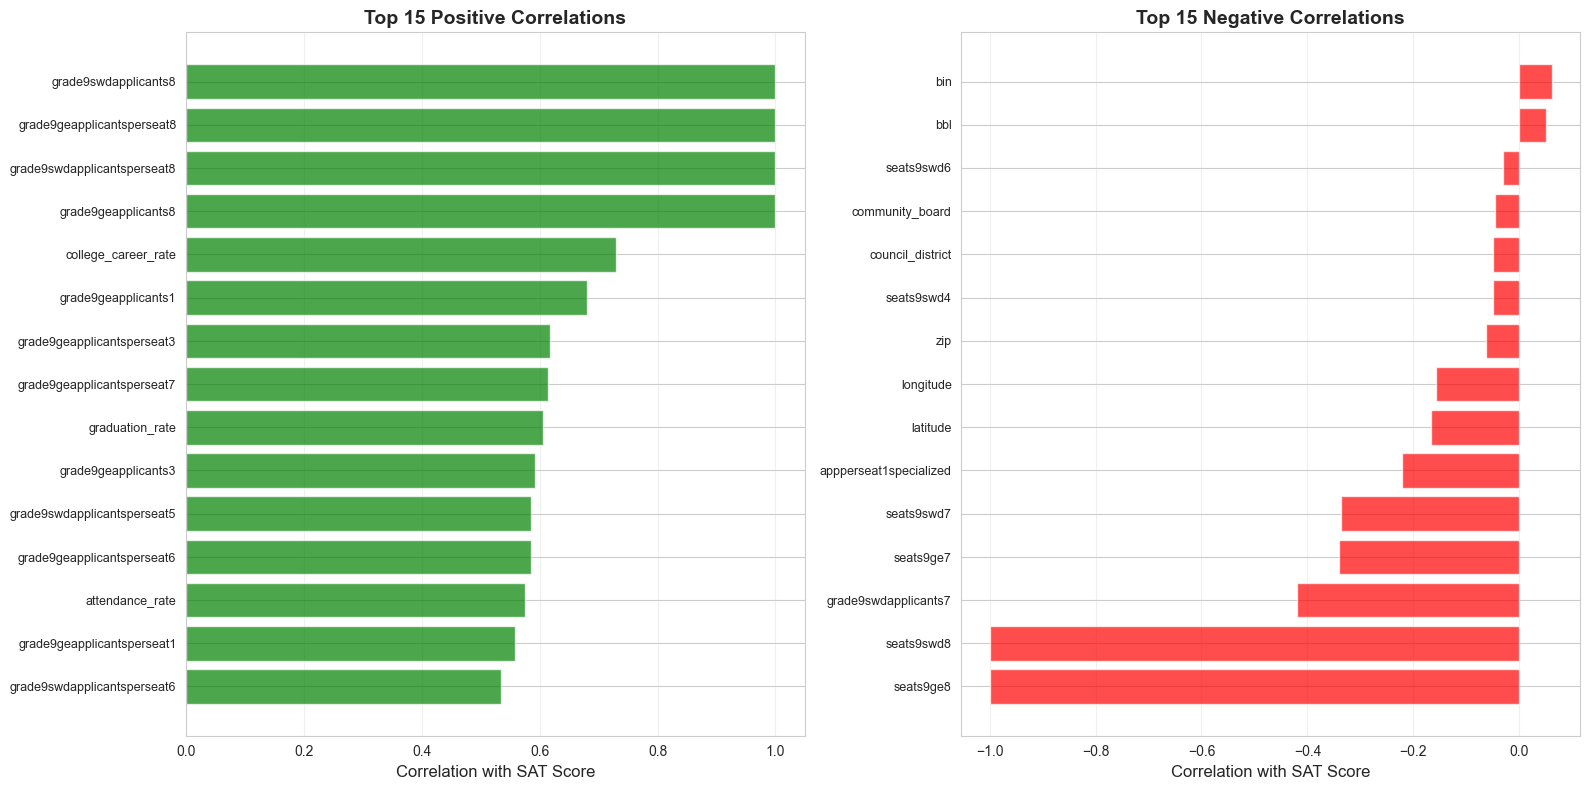


✅ Visualization complete!


In [9]:
# Visualize top correlations
if len(correlations) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 15 positive correlations
    top_positive = correlations.head(15)
    axes[0].barh(range(len(top_positive)), top_positive.values, color='green', alpha=0.7)
    axes[0].set_yticks(range(len(top_positive)))
    axes[0].set_yticklabels([col[:40] for col in top_positive.index], fontsize=9)
    axes[0].set_xlabel('Correlation with SAT Score', fontsize=12)
    axes[0].set_title('Top 15 Positive Correlations', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Top 15 negative correlations
    top_negative = correlations.tail(15)
    axes[1].barh(range(len(top_negative)), top_negative.values, color='red', alpha=0.7)
    axes[1].set_yticks(range(len(top_negative)))
    axes[1].set_yticklabels([col[:40] for col in top_negative.index], fontsize=9)
    axes[1].set_xlabel('Correlation with SAT Score', fontsize=12)
    axes[1].set_title('Top 15 Negative Correlations', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete!")

## 6. Text Analysis - Programs and Offerings

In [10]:
# Analyze text columns for common keywords
text_cols = merged.select_dtypes(include=['object']).columns.tolist()

# Look for program-related text columns
program_text_cols = [col for col in text_cols if any(kw in col.lower() for kw in ['program', 'language', 'course', 'offer'])]

if program_text_cols:
    print(f"📚 TEXT COLUMNS ABOUT PROGRAMS ({len(program_text_cols)} columns):\n")
    for col in program_text_cols[:10]:
        print(f"\n{col}:")
        # Count non-null values
        non_null = merged[col].notna().sum()
        print(f"  Schools with data: {non_null}/{len(merged)} ({non_null/len(merged)*100:.1f}%)")
        
        # Show sample
        sample = merged[col].dropna().head(2)
        for val in sample:
            print(f"  Sample: {str(val)[:150]}...")

📚 TEXT COLUMNS ABOUT PROGRAMS (22 columns):


ell_programs:
  Schools with data: 335/335 (100.0%)
  Sample: English as a New Language...
  Sample: English as a New Language...

offer_rate1:
  Schools with data: 231/335 (69.0%)
  Sample: Â—5% of offers went to this group...
  Sample: Â—63% of offers went to this group...

program1:
  Schools with data: 335/335 (100.0%)
  Sample: Orchard Collegiate Academy...
  Sample: University Neighborhood High School...

language_classes:
  Schools with data: 331/335 (98.8%)
  Sample: Spanish...
  Sample: Chinese (Mandarin), Spanish...

advancedplacement_courses:
  Schools with data: 266/335 (79.4%)
  Sample: AP US History...
  Sample: AP Calculus, AP Chinese, AP English, AP Spanish, AP Studio Art, AP US Government and Politics...

program2:
  Schools with data: 120/335 (35.8%)
  Sample: Bilingual Mandarin...
  Sample: The Urban Assembly School of Business for Young Women...

offer_rate2:
  Schools with data: 53/335 (15.8%)
  Sample: Â—15% of offers 

## 7. School Size Analysis

In [11]:
# Find enrollment/size columns
enrollment_cols = [col for col in numeric_cols if 'enroll' in col.lower() or 'student' in col.lower() or 'total' in col.lower()]

if enrollment_cols:
    print(f"👥 ENROLLMENT DATA ({len(enrollment_cols)} columns):\n")
    for col in enrollment_cols[:10]:
        if col in merged.columns:
            print(f"\n{col}:")
            print(f"  Mean: {merged[col].mean():.0f}")
            print(f"  Median: {merged[col].median():.0f}")
            print(f"  Range: {merged[col].min():.0f} - {merged[col].max():.0f}")
            
            # Correlation with SAT
            if col in correlations.index:
                print(f"  Correlation with SAT: {correlations[col]:+.3f}")

👥 ENROLLMENT DATA (1 columns):


total_students:
  Mean: 774
  Median: 482
  Range: 77 - 5534
  Correlation with SAT: +0.418


## 8. Create Feature Dataset for ML

In [12]:
# Select top correlated features for machine learning
if len(correlations) > 0:
    # Get top 20 positive and negative correlations
    top_features = list(correlations.head(20).index) + list(correlations.tail(20).index)
    
    # Create ML-ready dataset
    ml_data = merged[['dbn', 'school_name_sat', 'total_score'] + top_features].copy()
    
    # Remove rows with missing SAT scores
    ml_data = ml_data.dropna(subset=['total_score'])
    
    # Save for ML notebook
    from scripts.utils import save_csv
    save_csv(ml_data, "ml_features_dataset.csv", subfolder="processed", index=False)
    
    print(f"✅ ML-ready dataset created!")
    print(f"   Shape: {ml_data.shape}")
    print(f"   Schools: {len(ml_data)}")
    print(f"   Features: {len(top_features)}")
    print(f"\n📁 Saved to: data/processed/ml_features_dataset.csv")
    
    print(f"\n🎯 TOP FEATURES FOR MODELING:\n")
    for feat in top_features[:15]:
        print(f"  • {feat}")

✅ ML-ready dataset created!
   Shape: (294, 43)
   Schools: 294
   Features: 40

📁 Saved to: data/processed/ml_features_dataset.csv

🎯 TOP FEATURES FOR MODELING:

  • grade9swdapplicants8
  • grade9geapplicantsperseat8
  • grade9swdapplicantsperseat8
  • grade9geapplicants8
  • college_career_rate
  • grade9geapplicants1
  • grade9geapplicantsperseat3
  • grade9geapplicantsperseat7
  • graduation_rate
  • grade9geapplicants3
  • grade9swdapplicantsperseat5
  • grade9geapplicantsperseat6
  • attendance_rate
  • grade9geapplicantsperseat1
  • grade9swdapplicantsperseat6


## 9. Key Insights Summary

In [13]:
print("="*70)
print("🎓 DEMOGRAPHICS EXPLORATION - KEY FINDINGS")
print("="*70)

print(f"\n📊 Dataset Overview:")
print(f"   • Total columns explored: {len(demo.columns)}")
print(f"   • Schools with demographics: {len(demo)}")
print(f"   • Schools with SAT scores: {len(sat)}")
print(f"   • Schools with both: {len(merged)}")

print(f"\n🔢 Numeric Features:")
print(f"   • Numeric columns found: {len(numeric_cols)}")
print(f"   • Columns with correlations: {len(correlations)}")

if len(correlations) > 0:
    print(f"\n🔝 Strongest Positive Correlation:")
    top_pos = correlations.iloc[0]
    print(f"   • {correlations.index[0]}")
    print(f"   • Correlation: {top_pos:+.3f}")
    
    print(f"\n🔻 Strongest Negative Correlation:")
    top_neg = correlations.iloc[-1]
    print(f"   • {correlations.index[-1]}")
    print(f"   • Correlation: {top_neg:+.3f}")

print(f"\n📚 Column Categories Found:")
for category, cols in categorized_columns.items():
    print(f"   • {category}: {len(cols)} columns")

print(f"\n💡 Next Steps:")
print(f"   1. Use ml_features_dataset.csv for predictive modeling")
print(f"   2. Investigate top correlated features in detail")
print(f"   3. Explore text columns for qualitative insights")
print(f"   4. Build visualizations for top factors")

print("\n" + "="*70)
print("✅ Demographics Exploration Complete!")
print("="*70)

🎓 DEMOGRAPHICS EXPLORATION - KEY FINDINGS

📊 Dataset Overview:
   • Total columns explored: 343
   • Schools with demographics: 440
   • Schools with SAT scores: 460
   • Schools with both: 335

🔢 Numeric Features:
   • Numeric columns found: 111
   • Columns with correlations: 65

🔝 Strongest Positive Correlation:
   • grade9swdapplicants8
   • Correlation: +1.000

🔻 Strongest Negative Correlation:
   • seats9ge8
   • Correlation: -1.000

📚 Column Categories Found:
   • Programs: 72 columns
   • Enrollment: 63 columns
   • Location: 6 columns
   • Contact: 4 columns
   • Academic: 6 columns
   • Activities: 5 columns
   • Overview: 44 columns

💡 Next Steps:
   1. Use ml_features_dataset.csv for predictive modeling
   2. Investigate top correlated features in detail
   3. Explore text columns for qualitative insights
   4. Build visualizations for top factors

✅ Demographics Exploration Complete!


## 🎯 Next: Predictive Modeling

Now that we've identified key features, we can:
1. Build a model to predict SAT scores
2. Identify which factors matter most
3. Find schools that under/over-perform expectations

**Continue to:** `notebooks/predictive_modeling.ipynb`